<a href="https://colab.research.google.com/github/otang47/Landscape-Painting-Classification/blob/main/Cis107_CNN_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Loading your dataset**

Here we give an example of loading your dataset. We provide a python class called "**classification_dataset**" that will load data stored in subfolders of different catergorives, and process it to be in the same format as the following tutorial (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) -- so you can directly plug in a model.

For example, you want to have the folder struture as

Folder (e.g. Google_images) \
--- subfolder_1 (e.g. hip_hop_album) \
--- subfolder_2 (e.g. country_album)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from glob import glob
from PIL import Image
import os

In [ ]:
class classification_dataset(Dataset):
    def __init__(self, folder, size=128, to_tensor=False, mode=None, train_test_ratio=0.8):
        super().__init__()
        
        self.folder = folder
        self.subfolders = glob(folder + '/*')
        self.category = [sub.split('/')[-1] for sub in self.subfolders]
        self.size = size
        self.to_tensor = to_tensor
        
        image_files = []
        image_labels = []
        for i, c in enumerate(self.category):
            subfolder = folder + '/' + c
            files = sorted(glob(subfolder + '/*'))
            
            image_files += files
            image_labels += [i for _ in range(len(files))]
        
        self.image_files = image_files
        self.image_labels = image_labels
        
        
        self.transform = transforms.Compose([
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])
        
        
        self.index = self.set_mode(mode, train_test_ratio)
        
    def __getitem__(self, idx):
        index = self.index[idx]
        
        image = Image.open(self.image_files[index]).convert('RGB')
        image = image.resize([self.size, self.size])
        if self.to_tensor:
            image = self.transform(image)
        
        
        label = self.image_labels[index]
        return image, label
    
    def __len__(self):
        return len(self.index)
    
    
    def set_mode(self, mode, train_test_ratio):
        torch.manual_seed(0)
        
        num = len(self.image_files)
        index = torch.randperm(num)
        
        if mode == 'train':
            idx = int(num * train_test_ratio)
            index = index[:idx]
            
        elif mode == 'test':
            idx = int(num * train_test_ratio)
            index = index[idx:]
        
        index, _ = index.sort()
        return index

In [ ]:
dataset = classification_dataset(folder='drive/My Drive/Colab Notebooks/combined_images', size=224)
classes = ['Resized_Ming_Paintings', 'Resized_Song_Paintings']
len(dataset)

633

In [ ]:
"""
Copy from pytorch tutorial:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
"""

batch_size = 4

trainset = classification_dataset(folder='drive/My Drive/Colab Notebooks/combined_images', size=32, to_tensor=True, mode='train')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = classification_dataset(folder='drive/My Drive/Colab Notebooks/combined_images', size=32, to_tensor=True, mode='test')

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:
file_count = sum(len(files) for _, _, files in os.walk(r'drive/My Drive/Colab Notebooks/combined_images/Resized_Song_Paintings'))
print(file_count)

322


In [ ]:
file_count = sum(len(files) for _, _, files in os.walk(r'drive/My Drive/Colab Notebooks/combined_images/Resized_Ming_Paintings'))
print(file_count)

311


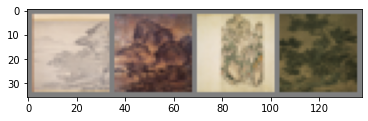

Resized_Ming_Paintings Resized_Song_Paintings Resized_Ming_Paintings Resized_Song_Paintings


In [ ]:
"""
Copy from pytorch tutorial:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
"""
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

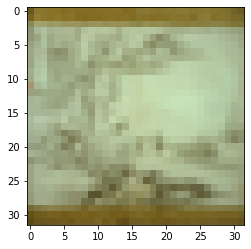

Resized_Ming_Paintings
506


In [ ]:
img, label = trainset[100]
imshow(img)
print(classes[label])
print(len(trainset))

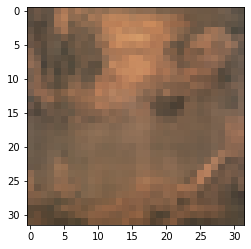

Resized_Song_Paintings
127


In [ ]:
img, label = testset[100]
imshow(img)
print(classes[label])
print(len(testset))

2. Define a Convolutional Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding='same') #rgb, # of filters, kernel size (5x5). 6 channels is like 6 layers
        #size of the mask, depends of the size of the image. 6 layers is b/c we trace back
        #from 10 number output, if we had a bigger image we would have more layers
        self.pool = nn.MaxPool2d(2, 2) #will take from every 2x2 so 16x16, the max value
        self.conv2 = nn.Conv2d(6, 16, 5, padding='same') #number of prev channels, 16 from pool, 5x5
        self.fc1 = nn.Linear(16 * 8 * 8, 120) #fully connected layer= takes info from whole image (8x8x16)
        #add them with weights 1x120 vector
        self.fc2 = nn.Linear(120, 84) #compress, small vector 1x24,
        self.fc3 = nn.Linear(84, 10) #compress, 1X10 with all info to do classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #becomes 16 x 16 x 6
        x = self.pool(F.relu(self.conv2(x))) #becomes 8 x 8 x 16
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x)) #for a network to be more express, 
                                #takes into account nonlinear, only pos values
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        #output the 10 numbers, 10 classes!


net = Net()

In [ ]:
print('size of batch:', images.shape)
x = net.pool(F.relu(net.conv1(images)))
print('after the first conv layer ', x.shape)
x = net.pool(F.relu(net.conv2(x)))
print('After the 2nd conv layer', x.shape)

size of batch: torch.Size([4, 3, 32, 32])
after the first conv layer  torch.Size([4, 6, 16, 16])
After the 2nd conv layer torch.Size([4, 16, 8, 8])


3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #how fast the network is learning, remember previous steps

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.

Compare ground truth (Ygt) with predicted (y^), tries to minimize y^ - Ygt, but redefining the weights of the coefficients of all the filters.

all networks have a loss function, cross rentropy is a formula that takes the log of its label and multiplies it with teh ground truth layer



In [ ]:
for epoch in range(50):  # loop over the dataset multiple times
    G_losses = []
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 180 == 1:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            # print (running_loss/ 10)
            G_losses.append(running_loss / 10)
            running_loss = 0.0
            

print('Finished Training')

[1,     2] loss: 0.029
[2,     2] loss: 0.049
[3,     2] loss: 0.039
[4,     2] loss: 0.047
[5,     2] loss: 0.071
[6,     2] loss: 0.027
[7,     2] loss: 0.064
[8,     2] loss: 0.024
[9,     2] loss: 0.040
[10,     2] loss: 0.017
[11,     2] loss: 0.026
[12,     2] loss: 0.031
[13,     2] loss: 0.036
[14,     2] loss: 0.032
[15,     2] loss: 0.041
[16,     2] loss: 0.177
[17,     2] loss: 0.036
[18,     2] loss: 0.070
[19,     2] loss: 0.037
[20,     2] loss: 0.098
[21,     2] loss: 0.038
[22,     2] loss: 0.060
[23,     2] loss: 0.070
[24,     2] loss: 0.031
[25,     2] loss: 0.045
[26,     2] loss: 0.025
[27,     2] loss: 0.022
[28,     2] loss: 0.021
[29,     2] loss: 0.027
[30,     2] loss: 0.021
[31,     2] loss: 0.058
[32,     2] loss: 0.061
[33,     2] loss: 0.035
[34,     2] loss: 0.075
[35,     2] loss: 0.038
[36,     2] loss: 0.058
[37,     2] loss: 0.061
[38,     2] loss: 0.055
[39,     2] loss: 0.071
[40,     2] loss: 0.103
[41,     2] loss: 0.040
[42,     2] loss: 0.126
[

Let's quickly save our trained model:



In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
for more details on saving PyTorch models.

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



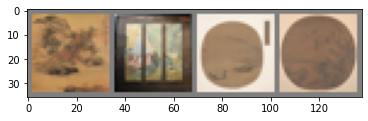

GroundTruth:  Resized_Ming_Paintings Resized_Ming_Paintings Resized_Ming_Paintings Resized_Ming_Paintings


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

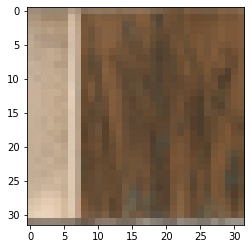

Resized_Ming_Paintings
506


In [ ]:
img, label = testset[50]
imshow(img)
print(classes[label])
print(len(trainset))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let's get the index of the highest energy:

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  Resized_Song_Paintings Resized_Ming_Paintings Resized_Ming_Paintings Resized_Song_Paintings


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 68 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Resized_Ming_Paintings is 78.6 %
Accuracy for class: Resized_Song_Paintings is 60.6 %


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train images: {100 * correct // total} %')

Accuracy of the network on the train images: 88 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Resized_Ming_Paintings is 78.6 %
Accuracy for class: Resized_Song_Paintings is 60.6 %


In [ ]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([2,2], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 127 test images: 68.50%


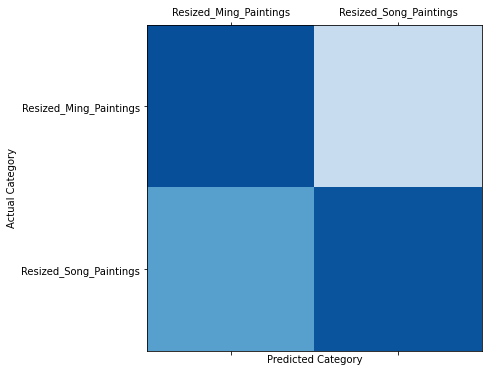

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=50, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(2), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(2), classes)
plt.show()

In [73]:
# plt.figure(figsize=(10,5))
# plt.title(" Loss During Training")
# plt.plot(G_losses,label="Loss")

# plt.xlabel("iterations")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()